Mulai ekstraksi fitur...
Bentuk fitur training: (285, 1792)
Bentuk target training: (285, 5)
Bentuk fitur validasi: (72, 1792)
Bentuk target validasi: (72, 5)

Mulai training XGBoost (satu model per target)...
  -> Melatih model untuk: Dry_Clover_g...
  -> Melatih model untuk: Dry_Dead_g...
  -> Melatih model untuk: Dry_Green_g...
  -> Melatih model untuk: Dry_Total_g...
  -> Melatih model untuk: GDM_g...

✅ Pelatihan XGBoost Selesai.

=== Validation Metrics (RMSE) ===
Dry_Clover_g   : 12.957
Dry_Dead_g     : 11.217
Dry_Green_g    : 18.126
Dry_Total_g    : 20.701
GDM_g          : 18.214

Scatter plot validasi disimpan sebagai 'xgb_efficientnet_scatter_plot.png'.

Mulai ekstraksi fitur set test...
Bentuk fitur test: (1, 1792)
\n🎉 File 'submission.csv' berhasil dibuat!


,sample_id,target
0,ID1001187975__Dry_Clover_g,4.213541
1,ID1001187975__Dry_Dead_g,15.446898
2,ID1001187975__Dry_Green_g,28.414845
3,ID1001187975__Dry_Total_g,44.759895
4,ID1001187975__GDM_g,27.654335


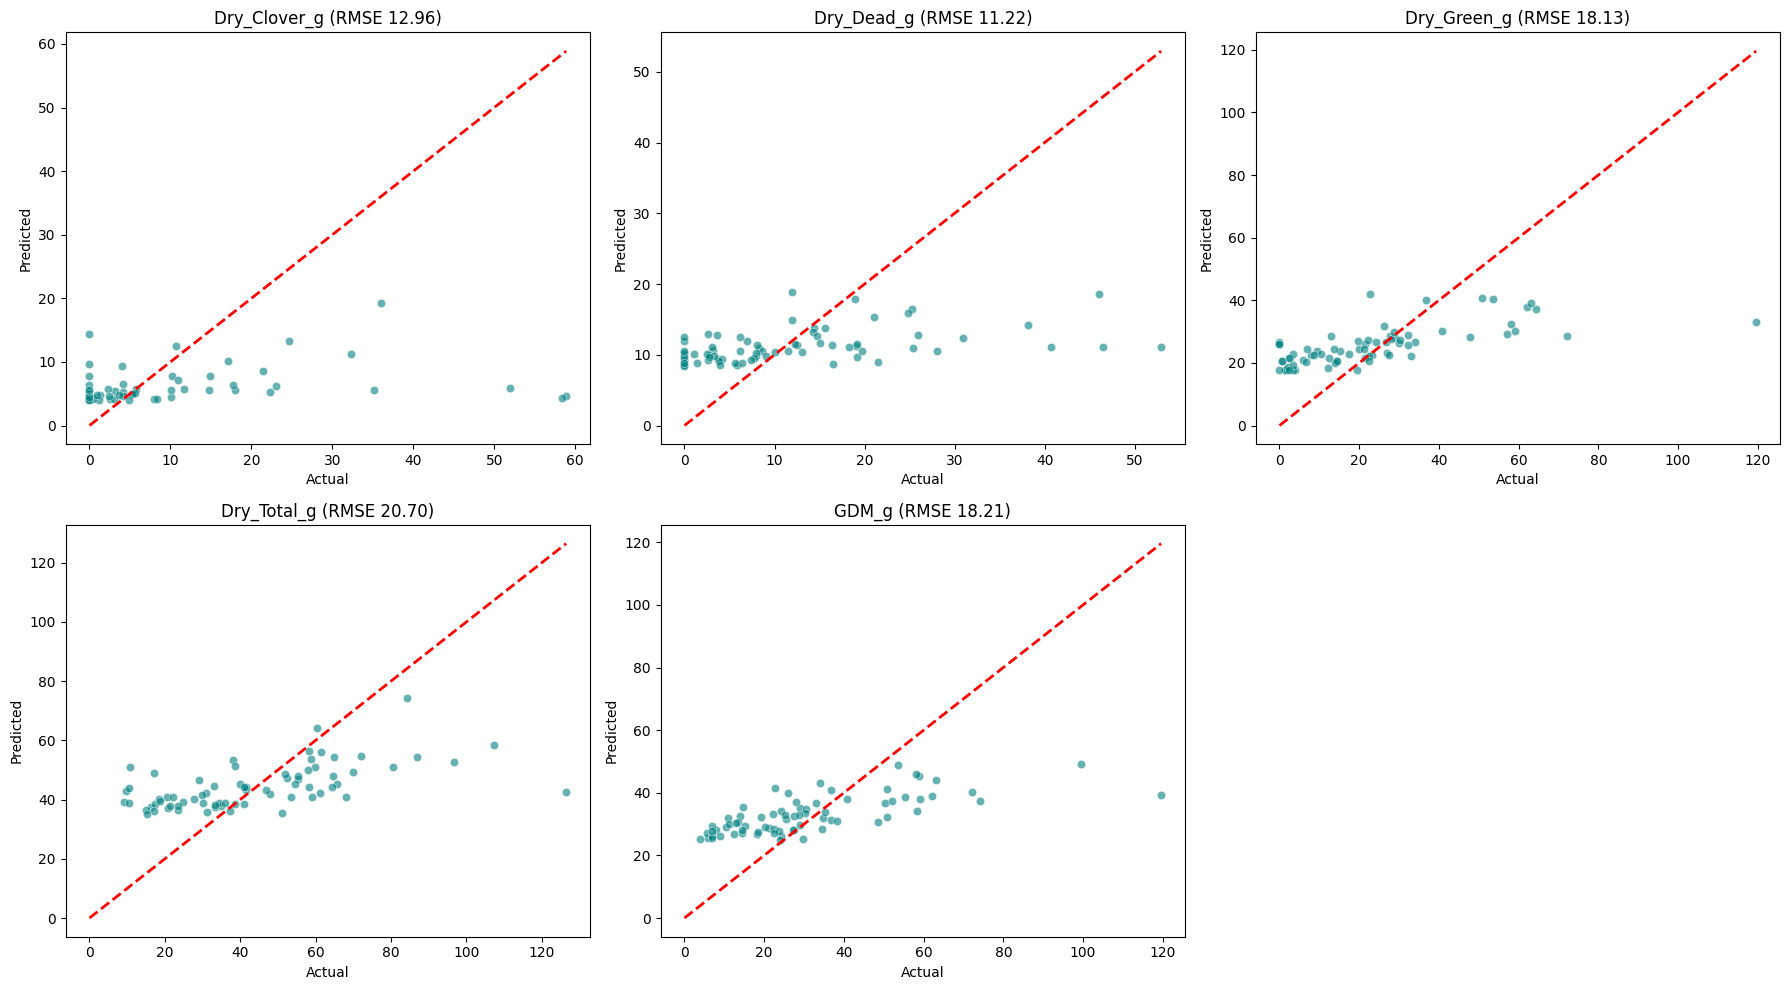

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Import baru untuk XGBoost
import xgboost as xgb

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================= PATH (ASUMSI SAMA DENGAN NOTEBOOK ANDA) =========================
INPUT_ROOT    = '/kaggle/input/csiro-biomass'
TRAIN_CSV     = f'{INPUT_ROOT}/train.csv'
TEST_CSV      = f'{INPUT_ROOT}/test.csv'
SAMPLE_SUB    = f'{INPUT_ROOT}/sample_submission.csv'
TRAIN_IMG_DIR = f'{INPUT_ROOT}/train'
TEST_IMG_DIR  = f'{INPUT_ROOT}/test'
MODEL_DIR = '/kaggle/input/efficientnetb4weight/pytorch/default/1/efficientnet_b4_rwightman-23ab8bcd.pth'

# ========================= DATA (REUSE) =========================
train_df = pd.read_csv(TRAIN_CSV)
train_pivot = train_df.pivot_table(index='image_path', columns='target_name', values='target').reset_index()

train_set, val_set = train_test_split(train_pivot, test_size=0.2, random_state=42)

# ========================= TRANSFORM (REUSE) =========================
# Transform standar untuk model ImageNet
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# ========================= DATASET (REUSE) =========================
class BiomassDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        # Target yang sama dengan ResNet50
        self.targets = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Menggunakan os.path.basename karena image_path di df pivot/split adalah path lengkap
        img_path = os.path.join(self.img_dir, os.path.basename(row['image_path']))
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img, row['image_path']
        else:
            targets = row[self.targets].values.astype(np.float32)
            return img, torch.from_numpy(targets)

# Buat DataLoader dengan shuffle=False untuk ekstraksi fitur yang konsisten
train_ds = BiomassDataset(train_set, TRAIN_IMG_DIR, transform)
val_ds   = BiomassDataset(val_set,   TRAIN_IMG_DIR, transform)

# NOTE: Di sini kita set shuffle=False agar urutan data konsisten saat ekstraksi fitur
train_dl = DataLoader(train_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# ========================= MODEL: EFFICIENTNETB4 FEATURE EXTRACTOR =========================
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # 1. Ganti ResNet50 dengan EfficientNetB4
        # Menggunakan weights pre-trained ImageNet (DEFAULT)
        # Efisiensi ini memiliki output final 1792 fitur (sebelum classifier)
        backbone = models.efficientnet_b4(weights=None)
        state_dict = torch.load(MODEL_DIR)
        backbone.load_state_dict(state_dict)
        self.features = backbone.features
        self.avgpool = backbone.avgpool
        
        # Fitur size EfficientNetB4 adalah 1792
        self.feature_size = backbone.classifier[1].in_features 

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # Flatten tensor ke vektor fitur
        x = torch.flatten(x, 1)
        return x

# Inisialisasi model ekstraktor
feature_extractor = FeatureExtractor().to(DEVICE)
TARGETS = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
N_TARGETS = len(TARGETS)


# ========================= FEATURE EXTRACTION DAN XGBOOST TRAINING =========================

def extract_features(model, dataloader):
    """Fungsi untuk menjalankan model PyTorch (extractor) dan mengumpulkan fitur/target."""
    model.eval()
    all_features = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(DEVICE)
            # Ekstraksi fitur
            features = model(xb).cpu().numpy()
            all_features.append(features)
            
            # Kumpulkan target (sudah dari dataloader)
            all_targets.append(yb.numpy())
            
    X = np.vstack(all_features)
    Y = np.vstack(all_targets)
    return X, Y

# --- 1. Ekstraksi Fitur ---
print("Mulai ekstraksi fitur...")
X_train_feat, Y_train = extract_features(feature_extractor, train_dl)
X_val_feat, Y_val = extract_features(feature_extractor, val_dl)
print(f"Bentuk fitur training: {X_train_feat.shape}")
print(f"Bentuk target training: {Y_train.shape}")
print(f"Bentuk fitur validasi: {X_val_feat.shape}")
print(f"Bentuk target validasi: {Y_val.shape}")


# --- 2. Pelatihan XGBoost (Menggantikan loop training PyTorch) ---
xgb_models = []
print("\nMulai training XGBoost (satu model per target)...")

for i, target_name in enumerate(TARGETS):
    print(f"  -> Melatih model untuk: {target_name}...")
    
    # Definisikan model XGBoost Regressor
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100, 
        learning_rate=0.005,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )
    
    # Latih model dengan fitur yang sudah diekstrak
    model.fit(X_train_feat, Y_train[:, i])
    xgb_models.append(model)

print("\n✅ Pelatihan XGBoost Selesai.")


# ========================= EVALUATION XGBOOST =========================
# Prediksi menggunakan XGBoost
preds_list = []
for i in range(N_TARGETS):
    pred = xgb_models[i].predict(X_val_feat)
    # Pastikan prediksi tidak negatif
    pred[pred < 0] = 0 
    preds_list.append(pred)

preds = np.array(preds_list).T # Bentuk (N_samples, N_targets)
trues = Y_val
# RMSE sudah dihitung di proses prediksi

print("\n=== Validation Metrics (RMSE) ===")
for i, name in enumerate(TARGETS):
    rmse = np.sqrt(mean_squared_error(trues[:, i], preds[:, i]))
    print(f"{name:15s}: {rmse:6.3f}")

# Scatter plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, name in enumerate(TARGETS):
    ax = axes[i]
    rmse = np.sqrt(mean_squared_error(trues[:, i], preds[:, i]))
    
    sns.scatterplot(x=trues[:, i], y=preds[:, i], ax=ax, alpha=0.6, color='teal')
    
    m = max(trues[:, i].max(), preds[:, i].max())
    if m > 1e-6:
        ax.plot([0, m], [0, m], 'r--', lw=2)
    
    ax.set_title(f"{name} (RMSE {rmse:.2f})")
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
    
fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('xgb_efficientnet_scatter_plot.png')
print("\nScatter plot validasi disimpan sebagai 'xgb_efficientnet_scatter_plot.png'.")


# ========================= INFERENSI DAN SUBMISSION =========================

def extract_test_features(model, dataloader):
    """Fungsi untuk menjalankan model PyTorch (extractor) dan mengumpulkan fitur/path."""
    model.eval()
    all_features = []
    all_paths = []
    
    with torch.no_grad():
        for xb, paths in dataloader:
            xb = xb.to(DEVICE)
            features = model(xb).cpu().numpy()
            all_features.append(features)
            all_paths.extend(paths)
            
    X_test = np.vstack(all_features)
    # Ambil hanya nama file sebagai kunci
    base_paths = [os.path.basename(p) for p in all_paths]
    
    return X_test, base_paths

# --- 1. Ekstraksi Fitur Set Test ---
print("\nMulai ekstraksi fitur set test...")
test_df_long = pd.read_csv(TEST_CSV)
unique_imgs = test_df_long[['image_path']].drop_duplicates().reset_index(drop=True)
test_ds = BiomassDataset(unique_imgs, TEST_IMG_DIR, transform, is_test=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True) # shuffle=False is critical

X_test_feat, test_image_paths = extract_test_features(feature_extractor, test_dl)
print(f"Bentuk fitur test: {X_test_feat.shape}")

# --- 2. Prediksi XGBoost ---
test_predictions_list = []
for i in range(N_TARGETS):
    model = xgb_models[i]
    pred = model.predict(X_test_feat)
    # Pastikan prediksi tidak negatif
    pred[pred < 0] = 0
    test_predictions_list.append(pred)

preds_test = np.array(test_predictions_list).T # (N_samples, N_targets)

# --- 3. WIDE TO LONG TRANSFORMATION ---
preds_wide = pd.DataFrame(preds_test, columns=TARGETS)
preds_wide['image_path'] = test_image_paths 

preds_long = preds_wide.melt(
    id_vars=['image_path'],
    value_vars=TARGETS,
    var_name='target_name',
    value_name='target'
)

# --- 4. GABUNGKAN (MERGE) DAN SIMPAN ---
# Kunci yang digunakan di test_df_long juga harus berupa nama file saja
test_df_long['image_path_key'] = test_df_long['image_path'].apply(os.path.basename)

submission = pd.merge(
    test_df_long[['sample_id', 'image_path_key', 'target_name']],
    preds_long,
    left_on=['image_path_key', 'target_name'],
    right_on=['image_path', 'target_name'],
    how='left'
)

submission = submission[['sample_id', 'target']]
submission.to_csv('submission.csv', index=False)

print("\\n🎉 File 'submission.csv' berhasil dibuat!")
submission.head()